# Modelo de Rede U-Net com Backbone Densenet-121 Pré-Treinada

Conecta com base de dados armazenados no Google Drive

Baixando Dataset localmente

In [1]:
import zipfile
import os

zip_path = '/home/marcello/Documentos/dicoms/dataset_jana.zip'

json_path = '/home/marcello/Repositories/DICOM-Project-Pytorch/data/dataset10/dataset_jana.json'

extract_dir = '/home/marcello/Repositories/DICOM-Project-Pytorch/data/dataset'

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f'Arquivo zip extraído para: {extract_dir}')


Arquivo zip extraído para: /home/marcello/Repositories/DICOM-Project-Pytorch/data/dataset


Importação de bibliotecas para execução construção e visualização do modelo e do conjunto de dados

In [2]:
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import six

from sklearn.model_selection import train_test_split

from skimage.transform import resize
from scipy.ndimage import morphology as mp
from scipy.ndimage import rotate
from scipy.ndimage import gaussian_filter

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.keras.utils import get_source_inputs
from tensorflow.keras.layers import InputSpec
from tensorflow.keras.layers import Conv2D, UpSampling2D, Conv2DTranspose, MaxPooling2D, Concatenate
from tensorflow.keras.layers import Activation, SpatialDropout2D
from tensorflow.keras.layers import Input, Dropout, BatchNormalization, Flatten, AveragePooling2D
from tensorflow.keras.preprocessing.image import img_to_array

from tqdm import tqdm_notebook

from os import listdir

from keras import Model
from keras.utils import plot_model
from keras.saving import register_keras_serializable
from keras.utils import Sequence
from keras.losses import binary_crossentropy, BinaryCrossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.models import load_model
from keras import initializers
from keras import regularizers
from keras import constraints
from tensorflow.keras import backend as K
from keras.regularizers import l2
from keras.applications import DenseNet121

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')
import seaborn as sns
sns.set_style("white")

2024-10-15 21:21:04.648635: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 21:21:04.781343: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-15 21:21:04.816154: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-15 21:21:05.058404: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-15 21:21:06.109441: W tensorflow/compiler/tf2

In [3]:
img_size_ori = 101
img_size_target = (224, 840)
img_w_target = 224
img_h_target = 224

Classe geradora de dados. Evita com que todas as imagens sejam carregas em memória durante o tempo de execução. Cada batch irá ser carregado em demanda.

Referência para o padrão: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

São aplicados os filtros de erosão binária e dilatação binária nas máscaras. A erosão binária irá reduzir o tamanha da máscara, removendo possíveis ruídos na segmentação. O processo seguinte, de dilatação, irá aumentar novamente a máscara reduzida, tornando-a mais prevalente na imagem de verdade fundamental

Fonte: https://www.cs.auckland.ac.nz/courses/compsci773s1c/lectures/ImageProcessing-html/topic4.htm

In [4]:
class DataGenerator(Sequence):

    def __init__(self,
                 images,
                 labels,
                 batch_size=16,
                 dim=(224,224,3),
                 shuffle=True):
        'Initialization'
        self.dim = dim
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        list_IDs_temp = [k for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.images))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        batch_imgs = list()
        batch_labels = list()

        for i in list_IDs_temp:

            angle = random.choice([1, 2, 3, 4])
            hflip = random.choice([True, False])
            vflip = random.choice([True, False])

            img = load_img(self.images[i], target_size=self.dim)
            img = img_to_array(img)/255
            # img = gaussian_filter(img, sigma=1)
            img = np.rot90(img, k=angle)

            label = load_img(self.labels[i], target_size=self.dim, color_mode = "grayscale")
            label = img_to_array(label)[:,:,0]
            label = label != 0
            label = mp.binary_erosion(label)
            label = mp.binary_dilation(label)
            label = np.expand_dims((label)*1 , axis=2)
            label = np.rot90(label, k=angle)

            if hflip:
                img = np.flip(img, axis=1)
                label = np.flip(label, axis=1)

            if vflip:
                img = np.flip(img, axis=0)
                label = np.flip(label, axis=0)

            batch_imgs.append(img)
            batch_labels.append(label)

        return np.array(batch_imgs, dtype = np.float32), np.array(batch_labels, dtype = np.float32)

In [5]:
def display_sample(data_tuple, img_shape):
    X,y = data_tuple
    plt.figure(figsize=(8,8))
    plt.subplot(121)
    plt.imshow(X[0])
    plt.subplot(122)
    plt.imshow(np.reshape(y[0], img_shape))

### Construindo o Modelo U-Net

In [6]:
def __unet_conv_bn_relu(**conv_params):
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer)(input)

        norm = BatchNormalization()(conv)
        return Activation("relu")(norm)

    return f

def Upsample2D_block(filters, kernel_size=(3,3), upsample_rate=(2,2), skip=None):

    def layer(input_tensor):

        x = UpSampling2D(size=upsample_rate)(input_tensor)

        if skip is not None:
            x = Concatenate()([x, skip])

        x = __unet_conv_bn_relu(filters=filters, kernel_size=kernel_size)(x)

        x = __unet_conv_bn_relu(filters=filters, kernel_size=kernel_size)(x)

        return x
    return layer


In [7]:
def UnetDenseNet(input_shape):
    inputs = Input(input_shape, name = 'input')
    densenet = DenseNet121(include_top = False, weights = 'imagenet', pooling = 'max',
                        input_tensor = inputs, input_shape = input_shape)

    skip1 = densenet.get_layer("input").output
    skip2 = densenet.get_layer("conv1_conv").output
    skip3 = densenet.get_layer("pool2_relu").output
    skip4 = densenet.get_layer("pool3_relu").output

    center = densenet.get_layer("pool4_relu").output

    d1 = Upsample2D_block(filters=512, skip=skip4)(center)
    d2 = Upsample2D_block(filters=256, skip=skip3)(d1)
    d3 = Upsample2D_block(filters=128, skip=skip2)(d2)
    d4 = Upsample2D_block(filters=54,  skip=skip1)(d3)

    x = Conv2D(1, (3), padding="same", name='final_conv')(d4)
    x = Activation('sigmoid', name='sigmoid')(x)

    model = Model(inputs, x, name="DenseNet_U-Net")
    return model

In [8]:
import json
import os
from sklearn.model_selection import KFold

with open(json_path, 'r') as file:
  dataset = json.load(file)

train_img_files = []
train_mask_files = []

for file in dataset['data']['train']:
  train_img_files.append(os.path.join(dataset["imageOutputPath"], file['image']))
  train_mask_files.append(os.path.join(dataset["labelOutputPath"], file['label']))

train_df_ = pd.DataFrame(data={"filename": train_img_files, 'mask' : train_mask_files})
train_df = train_df_.sample(frac=1).reset_index(drop=True)

test_img_files = []
test_mask_files = []

for file in dataset['data']['test']:
  test_img_files.append(os.path.join(dataset["imageOutputPath"], file['image']))
  test_mask_files.append(os.path.join(dataset["labelOutputPath"], file['label']))

test_df_ = pd.DataFrame(data={"filename": test_img_files, 'mask' : test_mask_files})
test_df = test_df_.sample(frac=1).reset_index(drop=True)

In [9]:
print(train_df["filename"].size)
print(test_df["filename"].size)

1968
761


In [10]:
kf = KFold(n_splits = 5, shuffle=False)

In [11]:
alpha = 0.25
gamma = 2

@register_keras_serializable(package="unetDensenet", name="generalized_dice_coefficient")
def generalized_dice_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (
            K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

@register_keras_serializable(package="unetDensenet", name="dice_loss")
def dice_loss(y_true, y_pred):
    loss = 1 - generalized_dice_coefficient(y_true, y_pred)
    return loss

@register_keras_serializable(package="unetDensenet", name="bce_dice_loss")
def bce_dice_loss(y_true, y_pred):
    return (binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)) / 2.0

In [16]:
batch_size = 16
val_batch_size = 8

positive_image_indices = train_df[train_df['mask'].apply(lambda x: np.any(load_img(x, color_mode="grayscale")))].index
positive_df = train_df.loc[positive_image_indices].sample(n=len(train_df) - 2 * len(positive_image_indices), replace=True)

oversamplet_train_df = pd.concat([train_df, positive_df], axis=0)

for k, (train_index, val_index) in enumerate(kf.split(oversamplet_train_df)):

    print(k)

    train_data_frame = oversamplet_train_df.iloc[train_index]
    val_data_frame = oversamplet_train_df.iloc[val_index]

    train_generator = DataGenerator(
        train_data_frame['filename'].values,
        train_data_frame['mask'].values,
        batch_size=batch_size,
        dim=(img_w_target,img_h_target, 3),
        shuffle=True)

    steps_per_epoch = len(train_data_frame["filename"]) // batch_size

    val_generator = DataGenerator(
        val_data_frame['filename'].values,
        val_data_frame['mask'].values,
        batch_size=val_batch_size,
        dim=(img_w_target,img_h_target, 3),
        shuffle=True)

    val_steps = len(val_data_frame["filename"]) // val_batch_size

    print('------------------------------------------------------------------------')
    print(f'Train DF size {len(train_data_frame)//batch_size} ...')
    print(f'Train Generator size {train_generator.__len__()} ...')
    print(f'Val DF size {len(val_data_frame)//val_batch_size} ...')
    print(f'Val Generator size {val_generator.__len__()} ...')
    print(f'Steps per epoch {steps_per_epoch} ...')
    print(f'Validation steps {val_steps} ...')

0
------------------------------------------------------------------------
Train DF size 155 ...
Train Generator size 155 ...
Val DF size 77 ...
Val Generator size 77 ...
Steps per epoch 155 ...
Validation steps 77 ...
1
------------------------------------------------------------------------
Train DF size 155 ...
Train Generator size 155 ...
Val DF size 77 ...
Val Generator size 77 ...
Steps per epoch 155 ...
Validation steps 77 ...
2
------------------------------------------------------------------------
Train DF size 155 ...
Train Generator size 155 ...
Val DF size 77 ...
Val Generator size 77 ...
Steps per epoch 155 ...
Validation steps 77 ...
3
------------------------------------------------------------------------
Train DF size 155 ...
Train Generator size 155 ...
Val DF size 77 ...
Val Generator size 77 ...
Steps per epoch 155 ...
Validation steps 77 ...
4
------------------------------------------------------------------------
Train DF size 155 ...
Train Generator size 155 ..

/tmp/ipykernel_77469/153977351.py:53: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  label = mp.binary_erosion(label)
/tmp/ipykernel_77469/153977351.py:54: DeprecationWarning: Please import `binary_dilation` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  label = mp.binary_dilation(label)


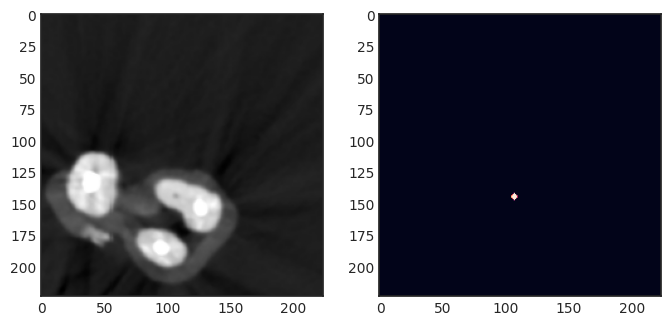

In [13]:
display_sample(train_generator.__getitem__(1), (224,224))
# display_sample(val_generator.__getitem__(24), (224,224))

Method for training model

In [14]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


I0000 00:00:1729038068.924218   77469 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729038069.213558   77469 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729038069.213752   77469 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [ ]:
batch_size = 16
val_bath_size = 8
epochs = 100

histories = []
losses = []
val_losses = []

fold_no = 1

models = []

for k, (train_index, val_index) in enumerate(kf.split(oversamplet_train_df)):

    model = UnetDenseNet(input_shape=(img_w_target,img_h_target, 3))

    model.compile(optimizer='adam',
                  loss=bce_dice_loss,
                  metrics = ['accuracy'])

    train_data_frame = oversamplet_train_df.iloc[train_index]
    val_data_frame = oversamplet_train_df.iloc[val_index]

    train_generator = DataGenerator(
        train_data_frame['filename'].values,
        train_data_frame['mask'].values,
        batch_size=batch_size,
        dim=(img_w_target,img_h_target, 3),
        shuffle=True)

    steps_per_epoch = len(train_data_frame["filename"]) // batch_size

    print('------------------------------------------------------------------------')
    print(f'Steps per epoch {steps_per_epoch} ...')

    val_generator = DataGenerator(
        val_data_frame['filename'].values,
        val_data_frame['mask'].values,
        batch_size=val_bath_size,
        dim=(img_w_target,img_h_target, 3),
        shuffle=True)

    val_steps = len(val_data_frame["filename"]) // val_bath_size

    mc = ModelCheckpoint(
        mode='min',
        monitor='val_loss',
        filepath=f'./data/checkpoints/fold_{fold_no}_top.model.weights.h5',
        save_best_only='True',
        save_weights_only='True',
        verbose=1)

    es = EarlyStopping(
        monitor='val_loss',
        min_delta=0.1,
        patience=10,
        verbose=1,
        restore_best_weights=True
    )

    callbacks = [mc]

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    model_history =  model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=callbacks)

    model_results = model.evaluate(val_generator)

    model_results = dict(zip(model.metrics_names,model_results))

    histories.append(model_history)
    losses.append(model_results['loss'])

    models.append(model)

    fold_no += 1

------------------------------------------------------------------------
Steps per epoch 155 ...
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100


/tmp/ipykernel_65278/153977351.py:53: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  label = mp.binary_erosion(label)
/tmp/ipykernel_65278/153977351.py:54: DeprecationWarning: Please import `binary_dilation` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  label = mp.binary_dilation(label)


155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.9832 - loss: 0.5230
Epoch 1: val_loss improved from inf to 1.26262, saving model to ./data/checkpoints/fold_1_top.model.weights.h5
155/155 ━━━━━━━━━━━━━━━━━━━━ 84s 239ms/step - accuracy: 0.9833 - loss: 0.5229 - val_accuracy: 0.6404 - val_loss: 1.2626
Epoch 2/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.9983 - loss: 0.4775
Epoch 2: val_loss improved from 1.26262 to 0.91826, saving model to ./data/checkpoints/fold_1_top.model.weights.h5
155/155 ━━━━━━━━━━━━━━━━━━━━ 34s 219ms/step - accuracy: 0.9983 - loss: 0.4773 - val_accuracy: 0.7598 - val_loss: 0.9183
Epoch 3/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.9975 - loss: 0.4811
Epoch 3: val_loss did not improve from 0.91826
155/155 ━━━━━━━━━━━━━━━━━━━━ 33s 212ms/step - accuracy: 0.9975 - loss: 0.4810 - val_accuracy: 0.8767 - val_loss: 1.0315
Epoch 4/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.9976 - loss: 0.3840
Epoch 4: val_loss impro

In [ ]:
for i, trained_model in enumerate(models):
  trained_model.save(f'/content/drive/MyDrive/TCC/models/9_densenet_cv.fold_{i}.model.keras')
  trained_model.save_weights(f'/content/drive/MyDrive/TCC/weights/9_densenet_cv.fold_{i}.weights.h5')

In [ ]:
import pickle

for i, history in enumerate(histories):
      print(history.history.keys())

      fig, (ax_train, ax_val) = plt.subplots(1, 2, figsize=(15,5))
      ax_train.plot(history.epoch, history.history["loss"], label="Perda de Treinamento")
      ax_train.legend(loc='upper right')
      ax_val.plot(history.epoch, history.history["val_loss"], label="Perda de Validação", color='orange')
      ax_val.legend(loc='upper right')

In [ ]:
with open('/content/drive/MyDrive/TCC/history/9_densene_cv_loss.pkl', 'wb') as f:
    pickle.dump(histories, f)

with open('/content/drive/MyDrive/TCC/history/9_densenet_cv_val_loss.pkl', 'wb') as f:
    pickle.dump(histories, f)

In [ ]:
# with open('/content/drive/MyDrive/TCC/history/model_history.pkl', 'rb') as f:
#     loaded_history = pickle.load(f)

In [19]:
def make_prediction(model,image,shape):
    img = img_to_array(load_img(image,target_size=shape))
    img = np.expand_dims(img,axis=0)/255.
    mask = model.predict(img, verbose=0)

    # mask = np.reshape(mask,(224,224,3))
    return mask

In [20]:
def overlay_mask(image, mask, color=(255, 0, 0), alpha=0.5):
    """
    Overlay a mask on an image.

    Args:
        image: The image to overlay the mask on.
        mask: The mask to overlay.
        color: The color of the mask.
        alpha: The transparency of the mask.

    Returns:
        The image with the mask overlayed.
    """
    print(type(mask))
    mask = np.where(mask > 0.5, 1, 0)

    image_with_mask = image.copy()

    image_with_mask[mask == 1] = image_with_mask[mask == 1] * alpha

    return image_with_mask


In [35]:
def get_predictions_and_labels(model, test_df):
     """Gets predictions and labels for all images in the test set."""
     all_predictions = []
     all_labels = []

     for image_path, mask_path in zip(test_df['filename'], test_df['mask']):
       predicted_probs = make_prediction(model, image_path, (img_w_target, img_h_target, 3))[0]
       predicted_probs = np.where(predicted_probs > 0.5, 1, 0).astype(int)
       predicted_probs = predicted_probs.squeeze()

       label = load_img(mask_path, target_size=(img_w_target, img_h_target, 3), color_mode="grayscale")
       label = img_to_array(label)[:, :, 0]
       label = np.where(label != 0, 1, 0).astype(int)
       label = label.squeeze()

       all_predictions.append(predicted_probs.flatten())
       all_labels.append(label.flatten())
     return np.concatenate(all_predictions), np.concatenate(all_labels)

In [27]:
model = UnetDenseNet(input_shape=(img_w_target,img_h_target, 3))

model.compile(optimizer='adam',
              loss=bce_dice_loss,
              metrics = ['accuracy'])


model.load_weights('./data/checkpoints/fold_1_top.model.weights.h5')
loaded_model_0 = model
print(loaded_model_0)
model.load_weights('./data/checkpoints/fold_2_top.model.weights.h5')
loaded_model_1 = model

models = [
    loaded_model_0,
    loaded_model_1
]

/home/marcello/Repositories/DICOM-Project-Pytorch/env/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 596 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


<Functional name=DenseNet_U-Net, built=True>


In [28]:
def generalized_dice_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score


def calculate_dice_accuracy(model, test_df):
     """Calculates the average Dice coefficient accuracy for all images in the test set."""
     dices = []
     for image_path, mask_path in zip(test_df['filename'], test_df['mask']):
       predicted_probs = make_prediction(model, image_path, (img_w_target, img_h_target, 3))[0]
       predicted_probs = predicted_probs.squeeze()

       label = load_img(mask_path, target_size=(img_w_target, img_h_target, 3), color_mode="grayscale")
       label = img_to_array(label)[:, :, 0]
       label = np.where(label != 0, 1, 0).astype(int)
       label = label.squeeze()

       predicted_mask = (predicted_probs > 0.5).astype(int)

       dice = generalized_dice_coefficient(label, predicted_mask)
       dices.append(K.get_value(dice))
     return np.mean(dices)

for model in models:
  accuracy = calculate_dice_accuracy(model, test_df)
  print(f"Average Dice Accuracy: {accuracy}")

I0000 00:00:1729038521.560182   79256 service.cc:146] XLA service 0x7f9a40004830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729038521.560225   79256 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2024-10-15 21:28:41.673312: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-15 21:28:42.208295: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1729038526.349043   79256 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Average Dice Accuracy: 0.8609115481376648
Average Dice Accuracy: 0.8609115481376648


In [29]:
def calculate_sensitivity_specificity(model, test_df):
    """Calculates sensitivity and specificity for all images in the test set."""
    all_predictions = []
    all_labels = []
    for image_path, mask_path in zip(test_df['filename'], test_df['mask']):
        predicted_probs = make_prediction(model, image_path, (img_w_target, img_h_target, 3))[0]
        predicted_probs = predicted_probs.squeeze()
        predicted_mask = (predicted_probs > 0.5).astype(int)
        predicted_mask = predicted_mask.flatten()

        label = load_img(mask_path, target_size=(img_w_target, img_h_target, 3), color_mode="grayscale")
        label = img_to_array(label)[:, :, 0]
        label = label != 0
        label = label.squeeze()
        label = label.astype(int)
        label = label.flatten()

        all_predictions.append(predicted_mask)
        all_labels.append(label)

    all_predictions = np.concatenate(all_predictions)
    all_labels = np.concatenate(all_labels)

    TP = np.sum((all_predictions == 1) & (all_labels == 1))
    FP = np.sum((all_predictions == 1) & (all_labels == 0))
    TN = np.sum((all_predictions == 0) & (all_labels == 0))
    FN = np.sum((all_predictions == 0) & (all_labels == 1))

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)

    return sensitivity, specificity

for model in models:
  sensitivity, specificity = calculate_sensitivity_specificity(model, test_df)
  print(f"Sensitivity (Recall): {sensitivity}")
  print(f"Specificity: {specificity}")

Sensitivity (Recall): 0.20354558022281857
Specificity: 0.9999787732188883
Sensitivity (Recall): 0.20354558022281857
Specificity: 0.9999787732188883


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [

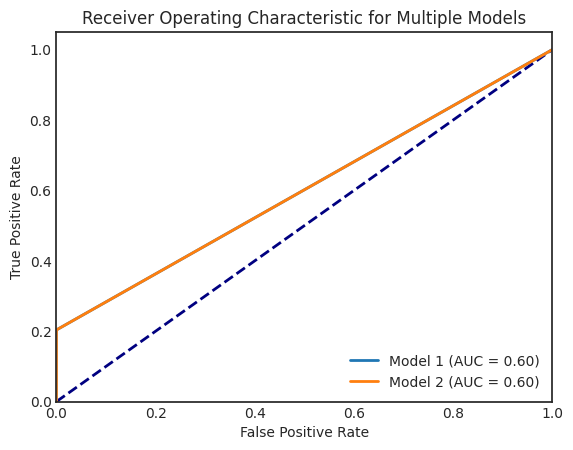

In [36]:
plt.figure()
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for reference

for i, model in enumerate(models):
    y_pred, y_true = get_predictions_and_labels(model, test_df)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Model {i+1} (AUC = {roc_auc:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multiple Models')
plt.legend(loc="lower right")
plt.show()

In [ ]:
save_path = '/content/drive/MyDrive/TCC/resultados_parciais_3'

model = models[2]

test_files_short = test_df['filename'][:50]

for test_file in test_files_short:

  split_name = test_file.split('/')
  slice_name = split_name[-1]
  image = test_file
  img = img_to_array(load_img(image, target_size=(img_w_target, img_h_target, 3))) / 255
  print(img.shape)

  plt.figure(figsize=(8,8))
  plt.axis('off')

  predicted_mask = make_prediction(model,image,(img_w_target, img_h_target, 3))[0]
  plt.imshow(predicted_mask)
  # plt.savefig(save_path + '/' + slice_name + '.predicted_mask.png', bbox_inches='tight', pad_inches=0)
  # plt.savefig(test_file + '.predicted_mask.png', bbox_inches='tight', pad_inches=0)

  plt.figure(figsize=(8,8))
  plt.axis('off')

  plt.imshow(overlay_mask(img, predicted_mask.squeeze(),color=(255, 0, 0), alpha=0.5))
  # plt.savefig(save_path + '/' + slice_name + '.overlay_mask.png',  bbox_inches='tight', pad_inches=0)
  # plt.savefig(test_file + '.overlay_mask.png', bbox_inches='tight', pad_inches=0)


In [ ]:
!pip install visualkeras

In [ ]:
import visualkeras

In [ ]:
# visualkeras.layered_view(model).show()
visualkeras.layered_view(
    model,
    type_ignore=[BatchNormalization, AveragePooling2D, Activation],
    to_file='output.png',
    legend=True,
    scale_xy=2, scale_z=0.5, max_z=5)

In [ ]:
print(model.summary())